## VIT Code with the bit-plane slicing

In [2]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.6 MB/s eta 0:00:00


In [3]:
import nibabel as nib
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import scipy.ndimage
from monai.networks.nets import resnet18
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight

2025-03-10 23:51:04.476240: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-10 23:51:04.515959: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-10 23:51:05.065503: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os

def find_files_with_substring(directory, substring):
    matching_files = [f for f in os.listdir(directory) if substring in f]
    return matching_files

def get_nib_image(adni_file_name):
    return nib.load(adni_file_name).get_fdata()

def visualize_image(nib_image):
    plt.imshow(nib_image[:,:,nib_image.shape[2]//2])
    plt.show()

In [3]:
def get_image_file_names_for_subject(subject_id, date=None):
    os.path.expanduser("~/adni_flat_dataset/adni_flat_dataset")
    dir_ = "/home/rittikar-s/adni_flat_dataset/adni_flat_dataset"
    files = find_files_with_substring(dir_, subject_id)
    if date:
        files = [file for file in files if date in file]
    file_paths = [f"{dir_}/{file}" for file in files]
    return file_paths

In [6]:
import pandas as pd

df = pd.read_csv("ADNI1_Complete_1Yr_1.5T_1_27_2025.csv")

In [25]:
from monai.networks.nets.vitautoenc import ViTAutoEnc

vit_model = ViTAutoEnc(in_channels=1, patch_size=(16,16,16), img_size=(128,128,128))

def get_vit_embedding(img):
    return vit_model(img)

In [6]:
class NiftiDataset(Dataset):
    def __init__(self, image_paths, labels, target_shape=(128, 128, 128)):
        self.image_paths = image_paths
        self.labels = labels
        self.target_shape = target_shape

    def __len__(self):
        return len(self.image_paths)

    def apply_multi_bit_plane_slicing(self, img_3d, bit_planes=[6, 7]):
        """
        Apply multi-bit-plane slicing to a 3D MRI image.
        
        Args:
            img_3d (torch.Tensor or np.ndarray): A 3D image (shape: [depth, height, width]).
            bit_planes (list of int): List of bit-planes to extract (0 = LSB, 7 = MSB).
        
        Returns:
            numpy.ndarray: The combined bit-plane image.
        """
        X, Y, Z = img_3d.shape
        processed_img = np.zeros_like(img_3d, dtype=np.uint8)
        
        if isinstance(img_3d, torch.Tensor):
            img_3d = img_3d.cpu().numpy()  # Convert to NumPy if it's a tensor
    
        for z in range(Z):  # Iterate through each slice dynamically
            slice_img = img_3d[:, :, z]  # Extract the 2D slice
            
            # Ensure the slice is in 8-bit format
            slice_img = (slice_img / np.max(slice_img) * 255).astype(np.uint8)  
            
            bit_sliced = np.zeros_like(slice_img, dtype=np.uint8)
    
            # Combine selected bit planes
            for bit in bit_planes:
                bit_sliced |= ((slice_img >> bit) & 1) << bit  
    
            processed_img[:, :, z] = bit_sliced  # Store processed slice back
    
        return processed_img
    
    def preprocess_nifti(self, nifti_path, threshold_value=80):
        # Load the NIfTI file
        img = nib.load(nifti_path).get_fdata()
    
        # Resize the image to the target shape
        img_resized = scipy.ndimage.zoom(img, np.array(self.target_shape) / np.array(img.shape), order=1)
    
        # Normalize intensity to [0, 1] for neural network
        img_normalized = (img_resized - np.min(img_resized)) / (np.max(img_resized) - np.min(img_resized) + 1e-8)
        # img_normalized = (img_normalized * 255).astype(np.uint8)  # You can adjust this based on model input needs
    
        # Create an empty array to store the processed result
        processed_img = self.apply_multi_bit_plane_slicing(img_normalized, [5, 6, 7])
    
        # Convert the processed image to a tensor and add a channel dimension (assuming 1 channel)
        return torch.tensor(processed_img, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    
    def __getitem__(self, idx):
        image = self.preprocess_nifti(self.image_paths[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        embedding = get_vit_embedding(image.reshape(1,1,128,128,128))
        return embedding, label

## Bit-Plane Slicing 

In [12]:
import os
import nibabel as nib
import numpy as np
import torch
import scipy.ndimage
from torch.utils.data import Dataset
from PIL import Image

def apply_multi_bit_plane_slicing(img_3d, bit_planes=[5, 6, 7]):
    """
    Apply multi-bit-plane slicing to a 3D MRI image.
    
    Args:
        img_3d (torch.Tensor or np.ndarray): A 3D image (shape: [depth, height, width]).
        bit_planes (list of int): List of bit-planes to extract (0 = LSB, 7 = MSB).
    
    Returns:
        numpy.ndarray: The combined bit-plane image.
    """
    if isinstance(img_3d, torch.Tensor):
        img_3d = img_3d.cpu().numpy()
    
    X, Y, Z = img_3d.shape
    processed_img = np.zeros_like(img_3d, dtype=np.uint8)
    
    for z in range(Z):
        slice_img = img_3d[:, :, z]
        slice_img = ((slice_img / np.max(slice_img)) * 255).astype(np.uint8)
        
        bit_sliced = np.zeros_like(slice_img, dtype=np.uint8)
        for bit in bit_planes:
            bit_sliced |= ((slice_img >> bit) & 1) << bit  
    
        processed_img[:, :, z] = bit_sliced
    
    return processed_img

def preprocess_nifti(nifti_path, target_shape=(128, 128, 128)):
    img = nib.load(nifti_path).get_fdata()
    
    # Resize image to target shape
    img_resized = scipy.ndimage.zoom(img, np.array(target_shape) / np.array(img.shape), order=1)
    
    # Normalize intensity to [0, 1]
    img_normalized = (img_resized - np.min(img_resized)) / (np.max(img_resized) - np.min(img_resized) + 1e-8)
    
    # Apply bit-plane slicing
    processed_img = apply_multi_bit_plane_slicing(img_normalized, [5, 6, 7])
    
    return torch.tensor(processed_img, dtype=torch.uint8).unsqueeze(0)  # Ensure uint8 for saving

def process_and_save_images(input_dir, output_dir, target_shape=(128, 128, 128)):
    os.makedirs(output_dir, exist_ok=True)
    
    for file in os.listdir(input_dir):
        if file.endswith(".nii"):
            nifti_path = os.path.join(input_dir, file)
            processed_img = preprocess_nifti(nifti_path, target_shape).squeeze().numpy()
            
            # Ensure image is in uint8 format before saving
            output_path = os.path.join(output_dir, file.replace(".nii", ".png"))
            Image.fromarray(processed_img[:, :, processed_img.shape[2] // 2].astype(np.uint8)).save(output_path)
    
    print(f"Preprocessed images saved to {output_dir}")

# Directories
input_dir = "flattened_images_2"
output_dir = "preprocessed_images_final_1"

process_and_save_images(input_dir, output_dir)

class NiftiDataset(Dataset):
    def __init__(self, image_paths, labels, target_shape=(128, 128, 128)):
        self.image_paths = image_paths
        self.labels = labels
        self.target_shape = target_shape

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = preprocess_nifti(self.image_paths[idx], self.target_shape)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        embedding = get_vit_embedding(image.reshape(1,1,128,128,128))
        return embedding, label


/tmp/ipykernel_2052450/1692703061.py:28: RuntimeWarning: invalid value encountered in divide
  slice_img = ((slice_img / np.max(slice_img)) * 255).astype(np.uint8)
/tmp/ipykernel_2052450/1692703061.py:28: RuntimeWarning: invalid value encountered in cast
  slice_img = ((slice_img / np.max(slice_img)) * 255).astype(np.uint8)


Preprocessed images saved to preprocessed_images_final_1


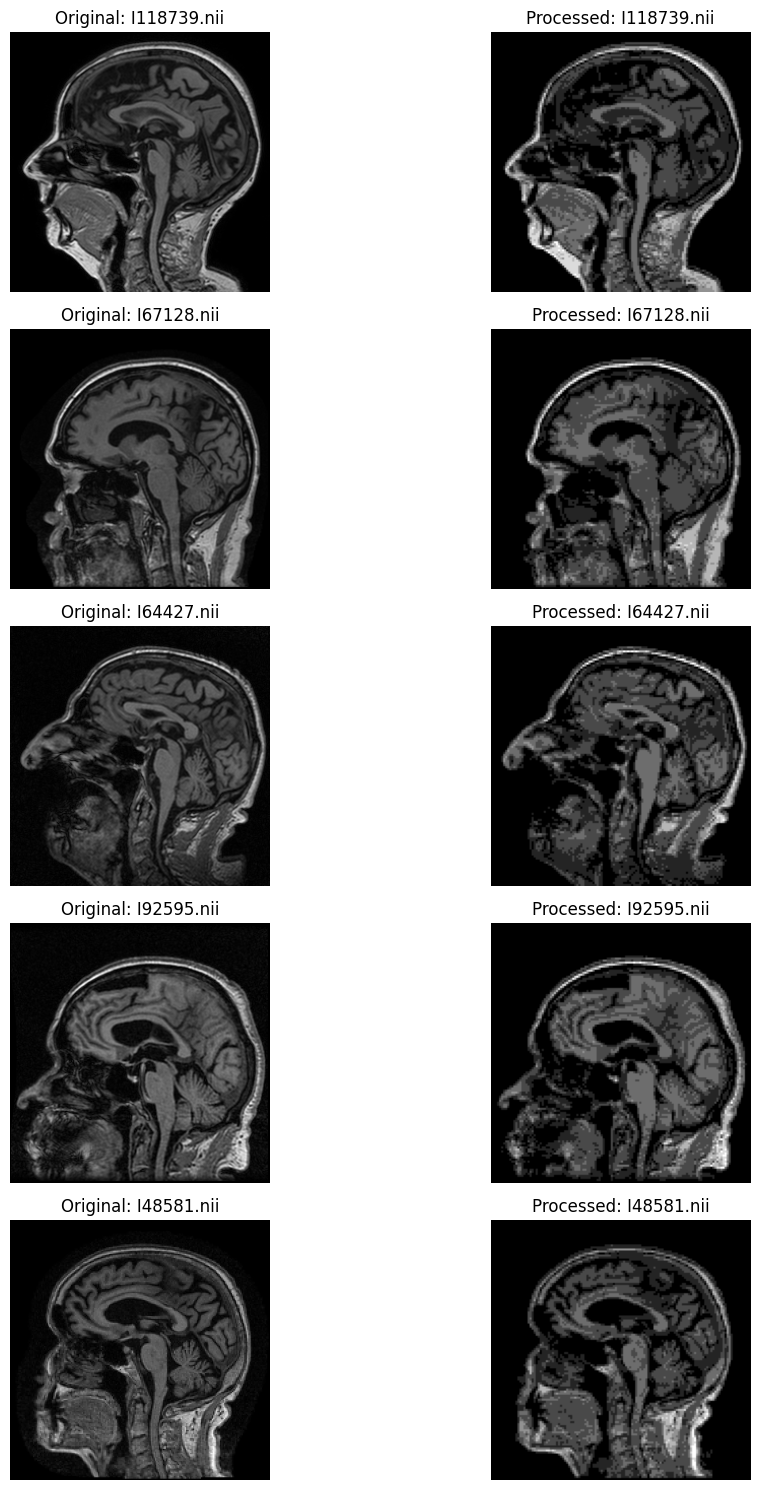

In [17]:
import matplotlib.pyplot as plt
import os
import nibabel as nib
import numpy as np
import cv2
from PIL import Image
import torch
from skimage import io, exposure
from skimage.filters import unsharp_mask
from skimage.restoration import denoise_bilateral

# Input and output directories
input_dir = "flattened_images_2"
output_dir = "preprocessed_images_final_1"
os.makedirs(output_dir, exist_ok=True)

# Select 5 sample images from both folders
sample_files = [f for f in os.listdir(input_dir) if f.endswith(".nii")][:5]

fig, axs = plt.subplots(5, 2, figsize=(12, 15))

for i, file in enumerate(sample_files):
    sample_file = os.path.join(input_dir, file)
    processed_file = os.path.join(output_dir, file.replace(".nii", ".png"))

    # Load original and processed images
    original_img_data = nib.load(sample_file).get_fdata()
    original_middle_slice = (original_img_data[:, :, original_img_data.shape[2] // 2] - original_img_data.min()) / (original_img_data.max() - original_img_data.min())
    processed_img = io.imread(processed_file, as_gray=True)

    # Display side-by-side
    axs[i, 0].imshow(original_middle_slice, cmap="gray")
    axs[i, 0].set_title(f"Original: {file}")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(processed_img, cmap="gray")
    axs[i, 1].set_title(f"Processed: {file}")
    axs[i, 1].axis("off")

plt.tight_layout()
plt.show()


## Aligning the tabular and the image directory

In [49]:
import pandas as pd
import os

# Reload the CSV file
csv_file_path = "ADNI1_Final_With_Biomarkers.csv"
metadata_df = pd.read_csv(csv_file_path)

# Define the processed images directory
processed_images_dir = "preprocessed_images_final_1"

# Extract the Image Data ID column from the CSV file
metadata_image_ids = metadata_df["Image Data ID"].astype(str)

# Get a list of processed image filenames (without extensions)
processed_image_ids = [os.path.splitext(file)[0] for file in os.listdir(processed_images_dir) if file.endswith(".png")]

# Align metadata and processed images
aligned_data = metadata_df[metadata_df["Image Data ID"].astype(str).isin(processed_image_ids)]

# Check if any images are missing from the processed images folder
missing_images = set(metadata_image_ids) - set(processed_image_ids)

# Output the aligned data and missing image IDs
aligned_data, missing_images

(     Image Data ID     Subject Group Sex  Age Visit Modality  \
 0           I97327  941_S_1311   MCI   M   69    sc      MRI   
 1          I112538  941_S_1311   MCI   M   70   m12      MRI   
 2           I97341  941_S_1311   MCI   M   70   m06      MRI   
 3           I63874  941_S_1202    CN   M   78    sc      MRI   
 4           I75150  941_S_1202    CN   M   78   m06      MRI   
 ...            ...         ...   ...  ..  ...   ...      ...   
 2289       I118671  002_S_0295    CN   M   85    sc      MRI   
 2290       I118692  002_S_0295    CN   M   85   m06      MRI   
 2291        I64025  002_S_0295    CN   M   86   m12      MRI   
 2292        I40966  002_S_0295    CN   M   85   m06      MRI   
 2293        I45108  002_S_0295    CN   M   85    sc      MRI   
 
                                      Description       Type    Acq Date  ...  \
 0       MPR; GradWarp; B1 Correction; N3; Scaled  Processed   3/02/2007  ...   
 1       MPR; GradWarp; B1 Correction; N3; Scaled  Proce

In [9]:
len(labels)

2294

## Splitting the data into training, val and test sets

In [50]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the aligned data (already matched with labels and images)
csv_file_path = "ADNI1_Final_With_Biomarkers.csv"
aligned_data.to_csv("aligned_metadata_3.csv", index=False)

# Define train, validation, and test split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Split data into training and temporary sets (for validation and testing)
train_data, temp_data = train_test_split(aligned_data, test_size=(1 - train_ratio), random_state=42, stratify=aligned_data["Group"])

# Further split temporary set into validation and test sets
val_data, test_data = train_test_split(temp_data, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42, stratify=temp_data["Group"])

# Save the split data for reference
train_data.to_csv("train_data_4.csv", index=False)
val_data.to_csv("val_data_4.csv", index=False)
test_data.to_csv("test_data_4.csv", index=False)

print(f"Data split completed:")
print(f"Training set: {len(train_data)} samples")
print(f"Validation set: {len(val_data)} samples")
print(f"Test set: {len(test_data)} samples")

Data split completed:
Training set: 1605 samples
Validation set: 344 samples
Test set: 345 samples


In [51]:
# Save the split data for reference
train_data.to_csv("train_data_4.csv", index=False)
val_data.to_csv("val_data_4.csv", index=False)
test_data.to_csv("test_data_4.csv", index=False)

print(f"Data split completed:")
print(f"Training set: {len(train_data)} samples")
print(f"Validation set: {len(val_data)} samples")
print(f"Test set: {len(test_data)} samples")

Data split completed:
Training set: 1605 samples
Validation set: 344 samples
Test set: 345 samples


## Vit from the huggingface library

In [44]:
from transformers import ViTForImageClassification
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", attn_implementation="sdpa", torch_dtype=torch.float16)
model

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [46]:
from transformers import ViTConfig, ViTModel

# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig()

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
configuration = model.config

print(configuration)

ViTConfig {
  "_attn_implementation_autoset": true,
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.3"
}



In [11]:
# Create train & test datasets
train_dataset = NiftiDataset(train_paths, train_labels)
val_dataset = NiftiDataset(val_paths, val_labels)
test_dataset = NiftiDataset(test_paths, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, pin_memory=True)

print(f"Train Batches: {len(train_loader)}, Val Batches: {len(val_loader)}, Test Batches: {len(test_loader)}")

Train Batches: 402, Val Batches: 86, Test Batches: 87


## Vit end to end training and evaluation (Without class weights!!!)

In [63]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ✅ Check CUDA availability
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to datasets and preprocessed images
train_csv = "train_data_4.csv"
val_csv = "val_data_4.csv"
test_csv = "test_data_4.csv"
image_dir = "preprocessed_images_final_1"

# Load Data Splits
train_data = pd.read_csv(train_csv)
val_data = pd.read_csv(val_csv)
test_data = pd.read_csv(test_csv)

# ✅ Load ViT Model and Feature Extractor
checkpoint = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor.from_pretrained(checkpoint)
model = ViTForImageClassification.from_pretrained(
    checkpoint, num_labels=3  # Number of classes: CN, MCI, AD
).to(device)  # ✅ Move model to CUDA

# Define label mapping
label_map = {"CN": 0, "MCI": 1, "AD": 2}

class MRIImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        img_path = os.path.join(self.image_dir, f"{row['Image Data ID']}.png")

        # Load Image
        image = Image.open(img_path).convert("RGB")

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Convert string label ('CN', 'MCI', 'AD') to integer (0, 1, 2)
        label = label_map[row["Group"]]  
        return image, label


# ✅ Define Transformations for ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Converts NumPy image to PyTorch Tensor
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)  # Ensure correct input scale for ViT
])

# ✅ Create PyTorch Dataloaders
batch_size = 8
train_dataset = MRIImageDataset(train_data, image_dir, transform=transform)
val_dataset = MRIImageDataset(val_data, image_dir, transform=transform)
test_dataset = MRIImageDataset(test_data, image_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# ✅ Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# ✅ Training Loop with Early Stopping
epochs = 10
best_val_loss = float("inf")
best_model_state = None
patience = 3
wait = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits  
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # ✅ Validation Step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)

    # ✅ Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

# ✅ Load Best Model
if best_model_state:
    model.load_state_dict(best_model_state)

# ✅ Evaluate Model on Test Set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"🔥 Test Accuracy: {test_acc:.4f}")

Using device: cuda:1


/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 1.0451, Train Acc: 0.4854, Val Loss: 1.0386, Val Acc: 0.4855
Epoch 2/10, Train Loss: 1.0302, Train Acc: 0.4854, Val Loss: 1.0087, Val Acc: 0.4942
Epoch 3/10, Train Loss: 0.8978, Train Acc: 0.6000, Val Loss: 0.9547, Val Acc: 0.5814
Epoch 4/10, Train Loss: 0.4734, Train Acc: 0.8474, Val Loss: 0.9816, Val Acc: 0.5930
Epoch 5/10, Train Loss: 0.1697, Train Acc: 0.9626, Val Loss: 1.0473, Val Acc: 0.6483
Epoch 6/10, Train Loss: 0.0570, Train Acc: 0.9969, Val Loss: 1.1693, Val Acc: 0.6337
Early stopping triggered.
🔥 Test Accuracy: 0.6232


In [53]:
import torch

# Function to extract embeddings from ViT model
def extract_embeddings(loader, model, device):
    model.eval()
    embeddings = []
    labels_list = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images, output_hidden_states=True)
            hidden_states = outputs.hidden_states[-1]  # Last hidden state
            pooled_output = hidden_states[:, 0]  # CLS token embedding
            embeddings.extend(pooled_output.cpu().numpy())
            labels_list.extend(labels.numpy())

    return embeddings, labels_list

# Extract embeddings for train, val, and test sets
train_embeddings_vit_1, train_labels = extract_embeddings(train_loader, model, device)
val_embeddings_vit_1, val_labels = extract_embeddings(val_loader, model, device)
test_embeddings_vit_1, test_labels = extract_embeddings(test_loader, model, device)

# Save embeddings to disk
torch.save({
    "train": {"embeddings": train_embeddings_vit_1, "labels": train_labels},
    "val": {"embeddings": val_embeddings_vit_1, "labels": val_labels},
    "test": {"embeddings": test_embeddings_vit_1, "labels": test_labels}
}, "vit_embeddings.pth")

print("Embeddings saved successfully!")


Embeddings saved successfully!


In [67]:
embeddings = torch.load("vit_embeddings.pth")
print(embeddings.keys())  # Should print: dict_keys(['train', 'val', 'test'])
print(embeddings["train"]["embeddings"].shape)  # Should print: (N_train, 768)


dict_keys(['train', 'val', 'test'])


/tmp/ipykernel_2052450/22976465.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load("vit_embeddings.pth")


AttributeError: 'list' object has no attribute 'shape'

In [70]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load embeddings
embeddings = torch.load("vit_embeddings.pth")

train_embeddings = torch.tensor(embeddings["train"]["embeddings"])
train_labels = torch.tensor(embeddings["train"]["labels"])

val_embeddings = torch.tensor(embeddings["val"]["embeddings"])
val_labels = torch.tensor(embeddings["val"]["labels"])


test_embeddings = torch.tensor(embeddings["test"]["embeddings"])
test_labels = torch.tensor(embeddings["test"]["labels"])

# ✅ Check Feature Shapes
print(f"Train Features Shape: {train_embeddings.shape}")  # Expected: (N_train, 768)
print(f"Val Features Shape:   {val_embeddings.shape}")  # Expected: (N_val, 768)
print(f"Test Features Shape:  {test_embeddings.shape}")  # Expected: (N_test, 768)

# ✅ Logistic Regression Model
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(train_embeddings, train_labels)

# ✅ Evaluate Logistic Regression
lr_preds = lr_model.predict(test_embeddings)
print("🔥 Logistic Regression Performance:")
print(classification_report(test_labels, lr_preds))
print(f"Test Accuracy (LR): {accuracy_score(test_labels, lr_preds):.4f}")

# ✅ MLP Classifier (Neural Network)
mlp_model = MLPClassifier(hidden_layer_sizes=(256, 256), activation='relu', solver='adam', max_iter=50, early_stopping=True)
mlp_model.fit(train_embeddings, train_labels)

# ✅ Evaluate MLP Classifier
mlp_preds = mlp_model.predict(test_embeddings)
print("🔥 MLP Classifier Performance:")
print(classification_report(test_labels, mlp_preds))
print(f"Test Accuracy (MLP): {accuracy_score(test_labels, mlp_preds):.4f}")

/tmp/ipykernel_2052450/3314532448.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load("vit_embeddings.pth")


Train Features Shape: torch.Size([1605, 768])
Val Features Shape:   torch.Size([344, 768])
Test Features Shape:  torch.Size([345, 768])
🔥 Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.55      0.54      0.54       106
           1       0.62      0.74      0.67       167
           2       0.67      0.39      0.49        72

    accuracy                           0.60       345
   macro avg       0.61      0.55      0.57       345
weighted avg       0.61      0.60      0.59       345

Test Accuracy (LR): 0.6029
🔥 MLP Classifier Performance:
              precision    recall  f1-score   support

           0       0.59      0.47      0.52       106
           1       0.60      0.81      0.69       167
           2       0.69      0.33      0.45        72

    accuracy                           0.61       345
   macro avg       0.62      0.54      0.55       345
weighted avg       0.61      0.61      0.59       345

Test Accur

In [71]:
import numpy as np
import torch

# Load embeddings
embeddings = torch.load("vit_embeddings.pth")

train_embeddings = np.array(embeddings["train"]["embeddings"])
train_labels = np.array(embeddings["train"]["labels"])

val_embeddings = np.array(embeddings["val"]["embeddings"])
val_labels = np.array(embeddings["val"]["labels"])

test_embeddings = np.array(embeddings["test"]["embeddings"])
test_labels = np.array(embeddings["test"]["labels"])

# ✅ Save embeddings as .npy files
np.save("train_embeddings_vit_1.npy", train_embeddings)
np.save("train_labels_vit_1.npy", train_labels)

np.save("val_embeddings_vit_1.npy", val_embeddings)
np.save("val_labels_vit_1.npy", val_labels)

np.save("test_embeddings_vit_1.npy", test_embeddings)
np.save("test_labels_vit_1.npy", test_labels)

print("✅ Embeddings and labels saved successfully!")


✅ Embeddings and labels saved successfully!


/tmp/ipykernel_2052450/1290073363.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load("vit_embeddings.pth")


## Multi Modal Fusions

### Early Fusion

In [72]:
train_features = np.load("train_embeddings_vit_1.npy")  # shape (num_train_samples, deit_feature_dim)
val_features   = np.load("val_embeddings_vit_1.npy")    # shape (num_val_samples,   deit_feature_dim)
test_features  = np.load("test_embeddings_vit_1.npy")   # shape (num_test_samples,  deit_feature_dim)

print("Vit Train Features Shape:", train_features.shape)
print("VIt Val Features Shape:  ", val_features.shape)
print("Vit Test Features Shape: ", test_features.shape)

ft_train = np.load("ft_train_embeddings.npy")  # shape: (num_train_samples, ft_feature_dim)
ft_val   = np.load("ft_val_embeddings.npy")      # shape: (num_val_samples,   ft_feature_dim)
ft_test  = np.load("ft_test_embeddings.npy")     # shape: (num_test_samples,  ft_feature_dim)
# -------------------------------------------------------------------
# 3. Concatenate DeiT features with TabNet embeddings
# -------------------------------------------------------------------
train_concat = np.concatenate([ft_train, train_features], axis=1)
val_concat   = np.concatenate([ft_val,   val_features],   axis=1)
test_concat  = np.concatenate([ft_test,  test_features],  axis=1)

print("\nConcatenated Train Shape:", train_concat.shape)
print("Concatenated Val Shape:  ", val_concat.shape)
print("Concatenated Test Shape: ", test_concat.shape)


Vit Train Features Shape: (1605, 768)
VIt Val Features Shape:   (344, 768)
Vit Test Features Shape:  (345, 768)

Concatenated Train Shape: (1605, 960)
Concatenated Val Shape:   (344, 960)
Concatenated Test Shape:  (345, 960)


In [73]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Set device.
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load and Concatenate Features
##########################################
# Load DeiT features.
vit_train = np.load("train_embeddings_vit_1.npy")  # shape: (num_train_samples, deit_feature_dim)
vit_val   = np.load("val_embeddings_vit_1.npy")      # shape: (num_val_samples,   deit_feature_dim)
vit_test  = np.load("test_embeddings_vit_1.npy")     # shape: (num_test_samples,  deit_feature_dim)

# Load FTTransformer features.
ft_train = np.load("ft_train_embeddings.npy")        # shape: (num_train_samples, ft_feature_dim)
ft_val   = np.load("ft_val_embeddings.npy")          # shape: (num_val_samples,   ft_feature_dim)
ft_test  = np.load("ft_test_embeddings.npy")         # shape: (num_test_samples,  ft_feature_dim)

# Concatenate features along the last axis.
train_features = np.concatenate((vit_train, ft_train), axis=1)
val_features   = np.concatenate((vit_val, ft_val), axis=1)
test_features  = np.concatenate((vit_test, ft_test), axis=1)

print("Fused train features shape:", train_features.shape)
print("Fused val features shape:", val_features.shape)
print("Fused test features shape:", test_features.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
# Read the CSV files (adjust filenames if needed)
train_data = pd.read_csv("train_data_4.csv")
val_data   = pd.read_csv("val_data_4.csv")
test_data  = pd.read_csv("test_data_4.csv")

# We assume the label column is named "Group"
label_col = "Group"

# Encode labels using LabelEncoder.
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])

num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# Convert features and labels to tensors.
train_features = torch.tensor(train_features, dtype=torch.float32)
val_features   = torch.tensor(val_features, dtype=torch.float32)
test_features  = torch.tensor(test_features, dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels   = torch.tensor(val_labels, dtype=torch.long)
test_labels  = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets.
train_dataset = TensorDataset(train_features, train_labels)
val_dataset   = TensorDataset(val_features, val_labels)
test_dataset  = TensorDataset(test_features, test_labels)

# Create DataLoaders.
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define an MLP Classifier for Fused Features
##########################################
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, x):
        return self.net(x)

# The input dimension is the sum of the two feature dimensions.
input_dim = train_features.shape[1]
hidden_dim = 128  # You can adjust this hyperparameter.
model_mlp = MLPClassifier(input_dim, hidden_dim, num_classes)
model_mlp.to(device)

##########################################
# 5. Train the MLP Classifier
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=1e-3)
num_epochs = 50

for epoch in range(num_epochs):
    model_mlp.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model_mlp(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_dataset)
    
    # Evaluate on the validation set.
    model_mlp.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model_mlp(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_acc = accuracy_score(all_targets, all_preds)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Acc = {val_acc:.4f}")

##########################################
# 6. Evaluate on the Test Set
##########################################
model_mlp.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model_mlp(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

Fused train features shape: (1605, 960)
Fused val features shape: (344, 960)
Fused test features shape: (345, 960)
Epoch 1/50: Train Loss = 1.0846, Val Acc = 0.7820
Epoch 2/50: Train Loss = 0.6083, Val Acc = 0.8343
Epoch 3/50: Train Loss = 0.4364, Val Acc = 0.7326
Epoch 4/50: Train Loss = 0.4260, Val Acc = 0.8198
Epoch 5/50: Train Loss = 0.3874, Val Acc = 0.8488
Epoch 6/50: Train Loss = 0.3581, Val Acc = 0.7820
Epoch 7/50: Train Loss = 0.3364, Val Acc = 0.8488
Epoch 8/50: Train Loss = 0.3303, Val Acc = 0.8576
Epoch 9/50: Train Loss = 0.3347, Val Acc = 0.8663
Epoch 10/50: Train Loss = 0.2933, Val Acc = 0.8634
Epoch 11/50: Train Loss = 0.3071, Val Acc = 0.8605
Epoch 12/50: Train Loss = 0.3135, Val Acc = 0.8023
Epoch 13/50: Train Loss = 0.3125, Val Acc = 0.8808
Epoch 14/50: Train Loss = 0.2974, Val Acc = 0.8198
Epoch 15/50: Train Loss = 0.2805, Val Acc = 0.8517
Epoch 16/50: Train Loss = 0.2908, Val Acc = 0.8779
Epoch 17/50: Train Loss = 0.2807, Val Acc = 0.8634
Epoch 18/50: Train Loss = 0

## So, 90.72% accuracy with early fusion - concatenation 

## Mid Fusion

In [75]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load Features (Uni-modal for each modality)
##########################################

# Load vit features.
deit_train = np.load("train_embeddings_vit_1.npy")  # shape: (num_train_samples, 768)
deit_val   = np.load("val_embeddings_vit_1.npy")      # shape: (num_val_samples, 768)
deit_test  = np.load("test_embeddings_vit_1.npy")     # shape: (num_test_samples, 768)

# Load FTTransformer features.
ft_train = np.load("ft_train_embeddings.npy")        # shape: (num_train_samples, 192)
ft_val   = np.load("ft_val_embeddings.npy")          # shape: (num_val_samples, 192)
ft_test  = np.load("ft_test_embeddings.npy")         # shape: (num_test_samples, 192)

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
# Read the CSV files (adjust filenames if needed)
train_data = pd.read_csv("train_data_4.csv")
val_data   = pd.read_csv("val_data_4.csv")
test_data  = pd.read_csv("test_data_4.csv")

# We assume the label column is named "Group"
label_col = "Group"

# Encode labels using LabelEncoder.
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])

num_classes = len(label_encoder.classes_)

##########################################
# 3. Create a Custom Dataset for Multi-Modal Data
##########################################
class MultiModalDataset(Dataset):
    def __init__(self, deit_features, ft_features, labels):
        self.deit_features = torch.tensor(deit_features, dtype=torch.float32)
        self.ft_features = torch.tensor(ft_features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.deit_features[idx], self.ft_features[idx], self.labels[idx]

train_dataset = MultiModalDataset(deit_train, ft_train, train_labels)
val_dataset   = MultiModalDataset(deit_val, ft_val, val_labels)
test_dataset  = MultiModalDataset(deit_test, ft_test, test_labels)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define the Mid-Fusion Classifier
##########################################
# Set projection dimensions.
proj_dim_deit = 128  # Project DeiT features from 768 to 384.
proj_dim_ft = 192    # Project FTTransformer features from 192 to 192.
hidden_dim = 128     # Hidden dimension for the classifier.

class MidFusionClassifier(nn.Module):
    def __init__(self, deit_dim, ft_dim, proj_dim_deit, proj_dim_ft, hidden_dim, num_classes):
        super(MidFusionClassifier, self).__init__()
        # Project DeiT features from deit_dim (768) to proj_dim_deit (384).
        self.deit_proj = nn.Linear(deit_dim, proj_dim_deit)
        # Project FTTransformer features from ft_dim (192) to proj_dim_ft (192).
        self.ft_proj   = nn.Linear(ft_dim, proj_dim_ft)
        # Fuse by concatenation. Fused dimension = proj_dim_deit + proj_dim_ft = 384 + 192 = 576.
        self.classifier = nn.Sequential(
            nn.Linear(proj_dim_deit + proj_dim_ft, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, deit, ft):
        deit_proj = self.deit_proj(deit)  # (batch_size, proj_dim_deit)
        ft_proj = self.ft_proj(ft)          # (batch_size, proj_dim_ft)
        fused = torch.cat((deit_proj, ft_proj), dim=1)  # (batch_size, proj_dim_deit + proj_dim_ft)
        out = self.classifier(fused)
        return out

# Hyperparameters for input dimensions.
deit_dim = deit_train.shape[1]  # expected 768
ft_dim = ft_train.shape[1]      # expected 192

model = MidFusionClassifier(deit_dim, ft_dim, proj_dim_deit, proj_dim_ft, hidden_dim, num_classes)
model.to(device)

##########################################
# 5. Train the Mid-Fusion Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100
patience = 10  # early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for deit_feat, ft_feat, labels in train_loader:
        deit_feat, ft_feat, labels = deit_feat.to(device), ft_feat.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(deit_feat, ft_feat)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
    train_loss /= len(train_dataset)
    
    # Evaluate on validation set.
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for deit_feat, ft_feat, labels in val_loader:
            deit_feat, ft_feat, labels = deit_feat.to(device), ft_feat.to(device), labels.to(device)
            logits = model(deit_feat, ft_feat)
            loss = criterion(logits, labels)
            val_loss += loss.item() * labels.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(labels.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_acc = accuracy_score(all_targets, all_preds)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for deit_feat, ft_feat, labels in test_loader:
        deit_feat, ft_feat, labels = deit_feat.to(device), ft_feat.to(device), labels.to(device)
        logits = model(deit_feat, ft_feat)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(labels.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Epoch 1/100: Train Loss = 0.5223, Val Loss = 0.4389, Val Acc = 0.8285
  -> New best model saved.
Epoch 2/100: Train Loss = 0.3741, Val Loss = 0.3041, Val Acc = 0.9012
  -> New best model saved.
Epoch 3/100: Train Loss = 0.3426, Val Loss = 0.4875, Val Acc = 0.7994
Epoch 4/100: Train Loss = 0.3470, Val Loss = 0.3135, Val Acc = 0.8808
Epoch 5/100: Train Loss = 0.3475, Val Loss = 0.3267, Val Acc = 0.8547
Epoch 6/100: Train Loss = 0.3367, Val Loss = 0.4432, Val Acc = 0.8314
Epoch 7/100: Train Loss = 0.3173, Val Loss = 0.3498, Val Acc = 0.8488
Epoch 8/100: Train Loss = 0.3380, Val Loss = 0.3334, Val Acc = 0.8808
Epoch 9/100: Train Loss = 0.3263, Val Loss = 0.3588, Val Acc = 0.8605
Epoch 10/100: Train Loss = 0.3138, Val Loss = 0.3970, Val Acc = 0.8343
Epoch 11/100: Train Loss = 0.3048, Val Loss = 0.3539, Val Acc = 0.8605
Epoch 12/100: Train Loss = 0.3143, Val Loss = 0.4040, Val Acc = 0.8430
Early stopping t

## Mid fusion - 91% accuracy

In [76]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load Features (Uni-modal for each modality)
##########################################

# Load vit features.
deit_train = np.load("train_embeddings_vit_1.npy")  # shape: (num_train_samples, 768)
deit_val   = np.load("val_embeddings_vit_1.npy")      # shape: (num_val_samples, 768)
deit_test  = np.load("test_embeddings_vit_1.npy")     # shape: (num_test_samples, 768)

# Load FTTransformer features.
ft_train = np.load("ft_train_embeddings.npy")        # shape: (num_train_samples, 192)
ft_val   = np.load("ft_val_embeddings.npy")          # shape: (num_val_samples, 192)
ft_test  = np.load("ft_test_embeddings.npy")         # shape: (num_test_samples, 192)

print("DeiT train features shape:", deit_train.shape)
print("FTTransformer train features shape:", ft_train.shape)

##########################################
# 2. Load Labels (from CSV files)
##########################################
# Read the CSV files (adjust filenames if needed)
train_data = pd.read_csv("train_data_4.csv")
val_data   = pd.read_csv("val_data_4.csv")
test_data  = pd.read_csv("test_data_4.csv")

# We assume the label column is named "Group"
label_col = "Group"

# Encode labels using LabelEncoder.
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label_col])
val_labels   = label_encoder.transform(val_data[label_col])
test_labels  = label_encoder.transform(test_data[label_col])

num_classes = len(label_encoder.classes_)

##########################################
# 3. Create a Custom Dataset for Multi-Modal Data
##########################################
class MultiModalDataset(Dataset):
    def __init__(self, deit_features, ft_features, labels):
        self.deit_features = torch.tensor(deit_features, dtype=torch.float32)
        self.ft_features = torch.tensor(ft_features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.deit_features[idx], self.ft_features[idx], self.labels[idx]

train_dataset = MultiModalDataset(deit_train, ft_train, train_labels)
val_dataset   = MultiModalDataset(deit_val, ft_val, val_labels)
test_dataset  = MultiModalDataset(deit_test, ft_test, test_labels)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define the Mid-Fusion Classifier
##########################################
# Set projection dimensions.
proj_dim_deit = 460  # Project DeiT features from 768 to 384.
proj_dim_ft = 170    # Project FTTransformer features from 192 to 192.
hidden_dim = 128     # Hidden dimension for the classifier.

class MidFusionClassifier(nn.Module):
    def __init__(self, deit_dim, ft_dim, proj_dim_deit, proj_dim_ft, hidden_dim, num_classes):
        super(MidFusionClassifier, self).__init__()
        # Project DeiT features from deit_dim (768) to proj_dim_deit (384).
        self.deit_proj = nn.Linear(deit_dim, proj_dim_deit)
        # Project FTTransformer features from ft_dim (192) to proj_dim_ft (192).
        self.ft_proj   = nn.Linear(ft_dim, proj_dim_ft)
        # Fuse by concatenation. Fused dimension = proj_dim_deit + proj_dim_ft = 384 + 192 = 576.
        self.classifier = nn.Sequential(
            nn.Linear(proj_dim_deit + proj_dim_ft, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, deit, ft):
        deit_proj = self.deit_proj(deit)  # (batch_size, proj_dim_deit)
        ft_proj = self.ft_proj(ft)          # (batch_size, proj_dim_ft)
        fused = torch.cat((deit_proj, ft_proj), dim=1)  # (batch_size, proj_dim_deit + proj_dim_ft)
        out = self.classifier(fused)
        return out

# Hyperparameters for input dimensions.
deit_dim = deit_train.shape[1]  # expected 768
ft_dim = ft_train.shape[1]      # expected 192

model = MidFusionClassifier(deit_dim, ft_dim, proj_dim_deit, proj_dim_ft, hidden_dim, num_classes)
model.to(device)

##########################################
# 5. Train the Mid-Fusion Classifier with Early Stopping
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100
patience = 10  # early stopping patience
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for deit_feat, ft_feat, labels in train_loader:
        deit_feat, ft_feat, labels = deit_feat.to(device), ft_feat.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(deit_feat, ft_feat)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
    train_loss /= len(train_dataset)
    
    # Evaluate on validation set.
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for deit_feat, ft_feat, labels in val_loader:
            deit_feat, ft_feat, labels = deit_feat.to(device), ft_feat.to(device), labels.to(device)
            logits = model(deit_feat, ft_feat)
            loss = criterion(logits, labels)
            val_loss += loss.item() * labels.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(labels.cpu().numpy())
    val_loss /= len(val_dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_acc = accuracy_score(all_targets, all_preds)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        print("  -> New best model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model state.
model.load_state_dict(best_model_state)

##########################################
# 6. Evaluate on the Test Set
##########################################
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for deit_feat, ft_feat, labels in test_loader:
        deit_feat, ft_feat, labels = deit_feat.to(device), ft_feat.to(device), labels.to(device)
        logits = model(deit_feat, ft_feat)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(labels.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

DeiT train features shape: (1605, 768)
FTTransformer train features shape: (1605, 192)
Epoch 1/100: Train Loss = 0.8094, Val Loss = 0.3690, Val Acc = 0.8576
  -> New best model saved.
Epoch 2/100: Train Loss = 0.4086, Val Loss = 0.3407, Val Acc = 0.8459
  -> New best model saved.
Epoch 3/100: Train Loss = 0.3701, Val Loss = 0.3213, Val Acc = 0.8634
  -> New best model saved.
Epoch 4/100: Train Loss = 0.3660, Val Loss = 0.4249, Val Acc = 0.8314
Epoch 5/100: Train Loss = 0.3608, Val Loss = 0.4181, Val Acc = 0.8372
Epoch 6/100: Train Loss = 0.3441, Val Loss = 0.3800, Val Acc = 0.8576
Epoch 7/100: Train Loss = 0.3542, Val Loss = 0.3531, Val Acc = 0.8576
Epoch 8/100: Train Loss = 0.3621, Val Loss = 0.3882, Val Acc = 0.8372
Epoch 9/100: Train Loss = 0.3272, Val Loss = 0.3433, Val Acc = 0.8750
Epoch 10/100: Train Loss = 0.3572, Val Loss = 0.3792, Val Acc = 0.8488
Epoch 11/100: Train Loss = 0.3427, Val Loss = 0.3522, Val Acc = 0.8779
Epoch 12/100: Train Loss = 0.3326, Val Loss = 0.3790, Val Ac

## Mid fusion with optimal no. of dimentions for ft and vit features (93%)

## Late fusion ... to be done soon ....

In [55]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report

# Load embeddings
embeddings = torch.load("vit_embeddings.pth")

train_embeddings = torch.tensor(embeddings["train"]["embeddings"])
train_labels = torch.tensor(embeddings["train"]["labels"])

val_embeddings = torch.tensor(embeddings["val"]["embeddings"])
val_labels = torch.tensor(embeddings["val"]["labels"])


test_embeddings = torch.tensor(embeddings["test"]["embeddings"])
test_labels = torch.tensor(embeddings["test"]["labels"])

# Create DataLoader
batch_size = 8

train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
test_dataset = TensorDataset(test_embeddings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define MLP classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 512)
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(512, 256)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        if x.shape[0] > 1:
            x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
    
        x = self.fc2(x)
        if x.shape[0] > 1:
            x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
    
        x = self.fc3(x)
        if x.shape[0] > 1:
            x = self.batch_norm3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        return x

# Model configuration
input_dim = train_embeddings.shape[1]
num_classes = len(torch.unique(train_labels))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLPClassifier(input_dim, num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 20
best_val_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for embeddings, labels in train_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds, val_targets = [], []

    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_targets.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_targets, val_preds)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_mlp_model.pth")
        print("Best model saved!")

# Evaluate on test set
model.load_state_dict(torch.load("best_mlp_model.pth"))
model.eval()

test_preds, test_targets = [], []
with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        outputs = model(embeddings)
        preds = outputs.argmax(dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, test_preds)
report = classification_report(test_targets, test_preds)

print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:\n", report)

/tmp/ipykernel_2052450/3236500359.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load("vit_embeddings.pth")


Epoch [1/20] | Train Loss: 0.3204 | Val Loss: 1.0523 | Val Acc: 0.6163
Best model saved!
Epoch [2/20] | Train Loss: 0.1393 | Val Loss: 1.2127 | Val Acc: 0.6163
Epoch [3/20] | Train Loss: 0.0893 | Val Loss: 1.3035 | Val Acc: 0.6221
Epoch [4/20] | Train Loss: 0.1134 | Val Loss: 1.2468 | Val Acc: 0.6366
Epoch [5/20] | Train Loss: 0.0643 | Val Loss: 1.5475 | Val Acc: 0.6221
Epoch [6/20] | Train Loss: 0.0708 | Val Loss: 1.4867 | Val Acc: 0.6279
Epoch [7/20] | Train Loss: 0.0422 | Val Loss: 1.7025 | Val Acc: 0.6279
Epoch [8/20] | Train Loss: 0.0441 | Val Loss: 1.7245 | Val Acc: 0.6308
Epoch [9/20] | Train Loss: 0.0367 | Val Loss: 1.7851 | Val Acc: 0.6250
Epoch [10/20] | Train Loss: 0.0324 | Val Loss: 1.8804 | Val Acc: 0.6250
Epoch [11/20] | Train Loss: 0.0341 | Val Loss: 1.7836 | Val Acc: 0.6279
Epoch [12/20] | Train Loss: 0.0514 | Val Loss: 1.5489 | Val Acc: 0.6453
Epoch [13/20] | Train Loss: 0.0414 | Val Loss: 1.6954 | Val Acc: 0.6483
Epoch [14/20] | Train Loss: 0.0434 | Val Loss: 1.7917 |

/tmp/ipykernel_2052450/3236500359.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_mlp_model.pth"))


In [60]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report

# Load embeddings
embeddings = torch.load("vit_embeddings.pth")

train_embeddings = torch.tensor(embeddings["train"]["embeddings"])
train_labels = torch.tensor(embeddings["train"]["labels"])

val_embeddings = torch.tensor(embeddings["val"]["embeddings"])
val_labels = torch.tensor(embeddings["val"]["labels"])

test_embeddings = torch.tensor(embeddings["test"]["embeddings"])
test_labels = torch.tensor(embeddings["test"]["labels"])

# Create DataLoader
batch_size = 8

train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
test_dataset = TensorDataset(test_embeddings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define MLP classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 512)
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(512, 256)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        if x.shape[0] > 1:
            x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
    
        x = self.fc2(x)
        if x.shape[0] > 1:
            x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
    
        x = self.fc3(x)
        if x.shape[0] > 1:
            x = self.batch_norm3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        return x

# Model configuration
input_dim = train_embeddings.shape[1]
num_classes = len(torch.unique(train_labels))
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = MLPClassifier(input_dim, num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 20
best_val_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for embeddings, labels in train_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds, val_targets = [], []

    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_targets.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_targets, val_preds)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_mlp_model.pth")
        print("Best model saved!")

# Evaluate on test set
model.load_state_dict(torch.load("best_mlp_model.pth"))
model.eval()

test_preds, test_targets = [], []
with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        outputs = model(embeddings)
        preds = outputs.argmax(dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, test_preds)
report = classification_report(test_targets, test_preds)

print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:\n", report)

/tmp/ipykernel_2052450/2031320306.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load("vit_embeddings.pth")


Epoch [1/20] | Train Loss: 0.3096 | Val Loss: 0.9954 | Val Acc: 0.6250
Best model saved!
Epoch [2/20] | Train Loss: 0.1254 | Val Loss: 1.1752 | Val Acc: 0.6279
Epoch [3/20] | Train Loss: 0.1021 | Val Loss: 1.4525 | Val Acc: 0.6163
Epoch [4/20] | Train Loss: 0.0782 | Val Loss: 1.3203 | Val Acc: 0.6221
Epoch [5/20] | Train Loss: 0.0692 | Val Loss: 1.3152 | Val Acc: 0.6395
Epoch [6/20] | Train Loss: 0.0585 | Val Loss: 1.2690 | Val Acc: 0.6483
Epoch [7/20] | Train Loss: 0.0493 | Val Loss: 1.4587 | Val Acc: 0.6279
Epoch [8/20] | Train Loss: 0.0532 | Val Loss: 1.4565 | Val Acc: 0.6308
Epoch [9/20] | Train Loss: 0.0517 | Val Loss: 1.9592 | Val Acc: 0.6337
Epoch [10/20] | Train Loss: 0.0446 | Val Loss: 1.4069 | Val Acc: 0.6424
Epoch [11/20] | Train Loss: 0.0482 | Val Loss: 1.4050 | Val Acc: 0.6395
Epoch [12/20] | Train Loss: 0.0258 | Val Loss: 1.6533 | Val Acc: 0.6308
Epoch [13/20] | Train Loss: 0.0195 | Val Loss: 1.7962 | Val Acc: 0.6279
Epoch [14/20] | Train Loss: 0.0419 | Val Loss: 1.6395 |

/tmp/ipykernel_2052450/2031320306.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_mlp_model.pth"))


In [40]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from transformers import ViTForImageClassification, ViTImageProcessor
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import os

# Device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Load metadata
csv_file_path = "ADNI1_Final_With_Biomarkers.csv"
metadata_df = pd.read_csv(csv_file_path)

# Encode labels
label_encoder = LabelEncoder()
metadata_df["Group"] = label_encoder.fit_transform(metadata_df["Group"])

# Get image paths and labels
image_paths = metadata_df["Image Data ID"].apply(lambda x: f"preprocessed_images_final_1/{x}.png").tolist()
labels = metadata_df["Group"].tolist()

# Split dataset into 70% train, 15% validation, 15% test
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, labels, test_size=0.3, random_state=42, stratify=labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

# Output dataset sizes
print(f"Train set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")
print(f"Test set: {len(test_paths)} images")

# Load HuggingFace ViT model and processor
model_name = "google/vit-base-patch16-224-in21k"
vit_model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(set(labels))).to(device)
processor = ViTImageProcessor.from_pretrained(model_name)

# Define dataset class
class MRI_Dataset(Dataset):
    def __init__(self, image_paths, labels, processor):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.processor(images=image, return_tensors="pt")["pixel_values"].squeeze()
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

# Create DataLoaders
batch_size = 8
dataloaders = {
    "train": DataLoader(MRI_Dataset(train_paths, train_labels, processor), batch_size=batch_size, shuffle=True),
    "val": DataLoader(MRI_Dataset(val_paths, val_labels, processor), batch_size=batch_size, shuffle=False),
    "test": DataLoader(MRI_Dataset(test_paths, test_labels, processor), batch_size=batch_size, shuffle=False),
}

# Define optimizer and loss function
optimizer = torch.optim.Adam(vit_model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

def train_vit(num_epochs=15, patience=5):
    best_val_loss = float("inf")
    patience_counter = 0
    best_model_path = "best_vit_model.pth"

    for epoch in range(num_epochs):
        vit_model.train()
        running_loss = 0.0
        for images, labels in dataloaders["train"]:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = vit_model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(dataloaders["train"])

        vit_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in dataloaders["val"]:
                images, labels = images.to(device), labels.to(device)
                outputs = vit_model(images).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(dataloaders["val"])
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(vit_model.state_dict(), best_model_path)
            print("Saved new best model!")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

    print("Training complete!")

# Train the ViT model with early stopping
train_vit(num_epochs=15, patience=5)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train set: 1605 images
Validation set: 344 images
Test set: 345 images
Epoch 1/15, Train Loss: 1.0486, Val Loss: 1.0412
Saved new best model!
Epoch 2/15, Train Loss: 1.0435, Val Loss: 1.0423
Epoch 3/15, Train Loss: 1.0431, Val Loss: 1.0420
Epoch 4/15, Train Loss: 1.0417, Val Loss: 1.0392
Saved new best model!
Epoch 5/15, Train Loss: 1.0411, Val Loss: 1.0374
Saved new best model!
Epoch 6/15, Train Loss: 1.0334, Val Loss: 1.0296
Saved new best model!
Epoch 7/15, Train Loss: 1.0193, Val Loss: 1.0312
Epoch 8/15, Train Loss: 0.9618, Val Loss: 1.0279
Saved new best model!
Epoch 9/15, Train Loss: 0.8363, Val Loss: 1.0688
Epoch 10/15, Train Loss: 0.6686, Val Loss: 1.0225
Saved new best model!
Epoch 11/15, Train Loss: 0.4216, Val Loss: 1.1750
Epoch 12/15, Train Loss: 0.2669, Val Loss: 1.3332
Epoch 13/15, Train Loss: 0.2080, Val Loss: 1.2868
Epoch 14/15, Train Loss: 0.1293, Val Loss: 1.5829
Epoch 15/15, Train Loss: 0.1373, Val Loss: 1.4975
Early stopping triggered!
Training complete!


In [42]:
import torch
from sklearn.metrics import accuracy_score, classification_report

# Load best model
vit_model.load_state_dict(torch.load("best_vit_model.pth"))
vit_model.to(device)
vit_model.eval()

all_preds, all_labels = [], []

# Evaluate on test set
with torch.no_grad():
    for images, labels in dataloaders["test"]:
        images, labels = images.to(device), labels.to(device)
        outputs = vit_model(images).logits
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy and classification report
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Detailed classification report
report = classification_report(all_labels, all_preds)
print(report)


/tmp/ipykernel_2052450/2854610886.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load("best_vit_model.pth"))


Test Accuracy: 0.5043
              precision    recall  f1-score   support

           0       0.46      0.29      0.36        72
           1       0.42      0.48      0.45       106
           2       0.57      0.61      0.59       167

    accuracy                           0.50       345
   macro avg       0.48      0.46      0.47       345
weighted avg       0.50      0.50      0.50       345



In [38]:
!nvidia-smi

Tue Mar 11 01:52:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4000               On  |   00000000:01:00.0 Off |                  Off |
| 41%   37C    P8             15W /  140W |   16088MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
# Create train & test datasets
train_dataset = NiftiDataset(train_paths, train_labels)
val_dataset = NiftiDataset(val_paths, val_labels)
test_dataset = NiftiDataset(test_paths, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Train Batches: {len(train_loader)}, Val Batches: {len(val_loader)}, Test Batches: {len(test_loader)}")

Train Batches: 201, Val Batches: 43, Test Batches: 44


In [22]:
import h5py

def save_embeddings_hdf5(dataloader, filename):
    """Save embeddings (from list format) and labels incrementally to an HDF5 file."""
    with h5py.File(filename, "w") as f:
        first_batch = True
        for i, (embedding_list, label) in enumerate(dataloader):
            # Extract the last layer embeddings
            embedding_tensor = embedding_list[1][-1]  # Extract final layer embeddings
            embedding_tensor = embedding_tensor.cpu().detach()  # Move to CPU
            
            embedding_numpy = embedding_tensor.numpy()  # Convert to NumPy
            label_numpy = label.cpu().numpy()

            # Reshape embeddings if needed
            embedding_numpy = embedding_numpy.reshape(embedding_numpy.shape[0], -1)  # (4, 1, 512, 768) → (4, 512 * 768)

            if first_batch:
                # Create expandable datasets with correct shape
                f.create_dataset("embeddings", data=embedding_numpy, 
                                 maxshape=(None, embedding_numpy.shape[1]))  # Now 2D
                f.create_dataset("labels", data=label_numpy, maxshape=(None,))
                first_batch = False
            else:
                # Resize and append new embeddings
                f["embeddings"].resize((f["embeddings"].shape[0] + embedding_numpy.shape[0]), axis=0)
                f["embeddings"][-embedding_numpy.shape[0]:] = embedding_numpy

                f["labels"].resize((f["labels"].shape[0] + label_numpy.shape[0]), axis=0)
                f["labels"][-label_numpy.shape[0]:] = label_numpy
            
            print(f"Saved embeddings for batch: {i+1}")

In [23]:
save_embeddings_hdf5(train_loader, "train_embeddings.h5")
save_embeddings_hdf5(val_loader, "val_embeddings.h5")
save_embeddings_hdf5(test_loader, "test_embeddings.h5")

ImageFileError: Cannot work out file type of "preprocessed_images_final/I40966.png"

In [24]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [25]:
def load_embeddings_hdf5(filename, batch_size=4):
    with h5py.File(filename, "r") as f:
        num_samples = f["embeddings"].shape[0]  # Total samples
        for i in range(0, num_samples, batch_size):
            X_batch = torch.tensor(f["embeddings"][i : i + batch_size], dtype=torch.float32).to(DEVICE)
            y_batch = torch.tensor(f["labels"][i : i + batch_size], dtype=torch.long).to(DEVICE)
            yield X_batch, y_batch

In [26]:
import torch.nn as nn
import torch.optim as optim

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(1024, 512)
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(512, 256)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(256, num_classes)  # Final layer

    def forward(self, x):
        x = self.fc1(x)
        if x.shape[0] > 1:  # Apply BatchNorm only if batch size > 1
            x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
    
        x = self.fc2(x)
        if x.shape[0] > 1:
            x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
    
        x = self.fc3(x)
        if x.shape[0] > 1:
            x = self.batch_norm3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        return x

In [34]:
input_dim = next(load_embeddings_hdf5("train_embeddings.h5"))[0].shape[1]  # Get feature size
num_classes = 3  # Adjust based on labels
model = MLPClassifier(input_dim, num_classes).to(DEVICE)

In [35]:
model

MLPClassifier(
  (fc1): Linear(in_features=393216, out_features=1024, bias=True)
  (batch_norm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (batch_norm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (batch_norm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=256, out_features=3, bias=True)
)

In [29]:
# Compute class weights
# classes = np.unique(train_labels)
# class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=train_labels)

# criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(DEVICE)).to(DEVICE)
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [30]:
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs!")
#     model = torch.nn.DataParallel(model)

# model = model.to("cuda") 

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from tqdm import tqdm  # Progress tracking

# Compute class weights
def compute_class_weights(y_train):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    return torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

y_train = np.concatenate([y.cpu().numpy() for _, y in load_embeddings_hdf5("train_embeddings.h5", batch_size=32)])
class_weights = compute_class_weights(y_train)

# Define optimizer, scheduler, and scaler
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scaler = torch.cuda.amp.GradScaler()

NUM_GPUS = 1
num_epochs = 100
patience = 15  # Early stopping patience
best_val_loss = float("inf")
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    # Training loop
    train_loader = load_embeddings_hdf5("train_embeddings.h5", batch_size=16 * NUM_GPUS)  # Adjust batch size
    train_bar = tqdm(train_loader, total=len(y_train) // (16 * NUM_GPUS), desc=f"Epoch {epoch+1}/{num_epochs} Train")
    for X_batch, y_batch in train_bar:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():  # Mixed precision
            outputs = model(X_batch)
            loss = F.cross_entropy(outputs, y_batch)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(y_batch).sum().item()
        total += y_batch.size(0)
        
        train_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

    train_accuracy = 100 * correct / total
    avg_train_loss = train_loss / total

    # Validation loop
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    val_loader = load_embeddings_hdf5("val_embeddings.h5", batch_size=16 * NUM_GPUS)
    val_bar = tqdm(val_loader, total=len(y_train) // (16 * NUM_GPUS), desc="Validation")
    with torch.no_grad():
        for X_val, y_val in val_bar:
            X_val, y_val = X_val.to(DEVICE), y_val.to(DEVICE)
            outputs = model(X_val)
            loss = F.cross_entropy(outputs, y_val)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(y_val).sum().item()
            val_total += y_val.size(0)

            val_bar.set_postfix(loss=loss.item(), acc=100 * val_correct / val_total)
    
    val_accuracy = 100 * val_correct / val_total
    avg_val_loss = val_loss / val_total

    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        epochs_without_improvement += 1

    # Stop if no improvement for 10 epochs
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}. No improvement in validation loss for {patience} epochs.")
        break

    # Learning rate scheduler step
    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.                         | 0/100 [00:00<?, ?it/s]
Epoch 1/100 Train: 101it [00:11,  8.62it/s, acc=33.8, loss=1.36]                                                                                            
Validation:  22%|██████████████████▋                                                                  | 22/100 [00:00<00:01, 52.61it/s, acc=47.7, loss=1.02]


Epoch [1/100]
  Train Loss: 0.0752 | Train Acc: 33.83%
  Val Loss: 0.0664 | Val Acc: 47.67%


Epoch 2/100 Train: 101it [00:11,  8.66it/s, acc=44.2, loss=0.791]                                                                                           
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.41it/s, acc=47.7, loss=0.952]


Epoch [2/100]
  Train Loss: 0.0678 | Train Acc: 44.17%
  Val Loss: 0.0656 | Val Acc: 47.67%


Epoch 3/100 Train: 101it [00:11,  8.61it/s, acc=48.2, loss=0.761]                                                                                           
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.09it/s, acc=51.2, loss=0.965]


Epoch [3/100]
  Train Loss: 0.0642 | Train Acc: 48.22%
  Val Loss: 0.0645 | Val Acc: 51.16%


Epoch 4/100 Train: 101it [00:11,  8.60it/s, acc=55.8, loss=0.698]                                                                                           
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.26it/s, acc=57.6, loss=0.859]


Epoch [4/100]
  Train Loss: 0.0583 | Train Acc: 55.83%
  Val Loss: 0.0622 | Val Acc: 57.56%


Epoch 5/100 Train: 101it [00:11,  8.60it/s, acc=59.5, loss=0.75]                                                                                            
Validation:  22%|██████████████████▉                                                                   | 22/100 [00:00<00:01, 53.43it/s, acc=61, loss=0.825]


Epoch [5/100]
  Train Loss: 0.0567 | Train Acc: 59.50%
  Val Loss: 0.0607 | Val Acc: 61.05%


Epoch 6/100 Train: 101it [00:11,  8.62it/s, acc=64.9, loss=0.827]                                                                                           
Validation:  22%|██████████████████▋                                                                  | 22/100 [00:00<00:01, 53.40it/s, acc=59.3, loss=0.78]


Epoch [6/100]
  Train Loss: 0.0530 | Train Acc: 64.92%
  Val Loss: 0.0596 | Val Acc: 59.30%


Epoch 7/100 Train: 101it [00:11,  8.63it/s, acc=68.2, loss=0.32]                                                                                            
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.97it/s, acc=60.8, loss=0.735]


Epoch [7/100]
  Train Loss: 0.0498 | Train Acc: 68.16%
  Val Loss: 0.0584 | Val Acc: 60.76%


Epoch 8/100 Train: 101it [00:11,  8.64it/s, acc=72.8, loss=0.556]                                                                                           
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.58it/s, acc=62.2, loss=0.703]


Epoch [8/100]
  Train Loss: 0.0459 | Train Acc: 72.77%
  Val Loss: 0.0570 | Val Acc: 62.21%


Epoch 9/100 Train: 101it [00:11,  8.65it/s, acc=76.1, loss=0.452]                                                                                           
Validation:  22%|███████████████████▏                                                                   | 22/100 [00:00<00:01, 52.17it/s, acc=61, loss=0.69]


Epoch [9/100]
  Train Loss: 0.0429 | Train Acc: 76.07%
  Val Loss: 0.0560 | Val Acc: 61.05%


Epoch 10/100 Train: 101it [00:11,  8.62it/s, acc=79.8, loss=0.47]                                                                                           
Validation:  22%|██████████████████▋                                                                  | 22/100 [00:00<00:01, 52.66it/s, acc=62.2, loss=0.66]


Epoch [10/100]
  Train Loss: 0.0401 | Train Acc: 79.75%
  Val Loss: 0.0547 | Val Acc: 62.21%


Epoch 11/100 Train: 101it [00:11,  8.66it/s, acc=83.8, loss=0.375]                                                                                          
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 51.82it/s, acc=63.1, loss=0.673]


Epoch [11/100]
  Train Loss: 0.0364 | Train Acc: 83.80%
  Val Loss: 0.0544 | Val Acc: 63.08%


Epoch 12/100 Train: 101it [00:11,  8.63it/s, acc=87, loss=0.45]                                                                                             
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.70it/s, acc=62.2, loss=0.645]


Epoch [12/100]
  Train Loss: 0.0328 | Train Acc: 87.04%
  Val Loss: 0.0535 | Val Acc: 62.21%


Epoch 13/100 Train: 101it [00:11,  8.63it/s, acc=88.1, loss=0.432]                                                                                          
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.77it/s, acc=64.5, loss=0.627]


Epoch [13/100]
  Train Loss: 0.0310 | Train Acc: 88.10%
  Val Loss: 0.0527 | Val Acc: 64.53%


Epoch 14/100 Train: 101it [00:11,  8.65it/s, acc=90.2, loss=0.2]                                                                                            
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 53.80it/s, acc=65.1, loss=0.562]


Epoch [14/100]
  Train Loss: 0.0278 | Train Acc: 90.16%
  Val Loss: 0.0519 | Val Acc: 65.12%


Epoch 15/100 Train: 101it [00:11,  8.61it/s, acc=92.3, loss=0.404]                                                                                          
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 51.89it/s, acc=64.2, loss=0.605]


Epoch [15/100]
  Train Loss: 0.0250 | Train Acc: 92.27%
  Val Loss: 0.0509 | Val Acc: 64.24%


Epoch 16/100 Train: 101it [00:11,  8.60it/s, acc=93.4, loss=0.295]                                                                                          
Validation:  22%|███████████████████▏                                                                   | 22/100 [00:00<00:01, 50.16it/s, acc=64, loss=0.57]


Epoch [16/100]
  Train Loss: 0.0230 | Train Acc: 93.40%
  Val Loss: 0.0498 | Val Acc: 63.95%


Epoch 17/100 Train: 101it [00:11,  8.63it/s, acc=94.6, loss=0.235]                                                                                          
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 53.01it/s, acc=63.7, loss=0.596]


Epoch [17/100]
  Train Loss: 0.0208 | Train Acc: 94.58%
  Val Loss: 0.0501 | Val Acc: 63.66%


Epoch 18/100 Train: 101it [00:11,  8.62it/s, acc=96.6, loss=0.233]                                                                                          
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 53.32it/s, acc=64.5, loss=0.566]


Epoch [18/100]
  Train Loss: 0.0185 | Train Acc: 96.64%
  Val Loss: 0.0498 | Val Acc: 64.53%


Epoch 19/100 Train: 101it [00:11,  8.61it/s, acc=97.3, loss=0.15]                                                                                           
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 51.79it/s, acc=66.3, loss=0.588]


Epoch [19/100]
  Train Loss: 0.0168 | Train Acc: 97.32%
  Val Loss: 0.0496 | Val Acc: 66.28%


Epoch 20/100 Train: 101it [00:11,  8.65it/s, acc=97.6, loss=0.18]                                                                                           
Validation:  22%|██████████████████▉                                                                   | 22/100 [00:00<00:01, 52.40it/s, acc=66, loss=0.549]


Epoch [20/100]
  Train Loss: 0.0154 | Train Acc: 97.63%
  Val Loss: 0.0484 | Val Acc: 65.99%


Epoch 21/100 Train: 101it [00:11,  8.63it/s, acc=98.3, loss=0.13]                                                                                           
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.77it/s, acc=65.1, loss=0.501]


Epoch [21/100]
  Train Loss: 0.0138 | Train Acc: 98.26%
  Val Loss: 0.0486 | Val Acc: 65.12%


Epoch 22/100 Train: 101it [00:11,  8.62it/s, acc=98.8, loss=0.13]                                                                                           
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 51.63it/s, acc=66.3, loss=0.515]


Epoch [22/100]
  Train Loss: 0.0129 | Train Acc: 98.82%
  Val Loss: 0.0482 | Val Acc: 66.28%


Epoch 23/100 Train: 101it [00:11,  8.63it/s, acc=98.8, loss=0.125]                                                                                          
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.62it/s, acc=63.1, loss=0.517]


Epoch [23/100]
  Train Loss: 0.0116 | Train Acc: 98.82%
  Val Loss: 0.0480 | Val Acc: 63.08%


Epoch 24/100 Train: 101it [00:11,  8.63it/s, acc=98.9, loss=0.113]                                                                                          
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.75it/s, acc=64.5, loss=0.556]


Epoch [24/100]
  Train Loss: 0.0109 | Train Acc: 98.94%
  Val Loss: 0.0488 | Val Acc: 64.53%


Epoch 25/100 Train: 101it [00:11,  8.63it/s, acc=99.2, loss=0.0903]                                                                                         
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.75it/s, acc=65.4, loss=0.463]


Epoch [25/100]
  Train Loss: 0.0101 | Train Acc: 99.19%
  Val Loss: 0.0480 | Val Acc: 65.41%


Epoch 26/100 Train: 101it [00:11,  8.61it/s, acc=99.1, loss=0.0918]                                                                                         
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.24it/s, acc=65.7, loss=0.538]


Epoch [26/100]
  Train Loss: 0.0092 | Train Acc: 99.13%
  Val Loss: 0.0478 | Val Acc: 65.70%


Epoch 27/100 Train: 101it [00:11,  8.66it/s, acc=99.3, loss=0.053]                                                                                          
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 53.01it/s, acc=65.4, loss=0.514]


Epoch [27/100]
  Train Loss: 0.0085 | Train Acc: 99.31%
  Val Loss: 0.0474 | Val Acc: 65.41%


Epoch 28/100 Train: 101it [00:11,  8.61it/s, acc=99.4, loss=0.088]                                                                                          
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.68it/s, acc=66.3, loss=0.554]


Epoch [28/100]
  Train Loss: 0.0081 | Train Acc: 99.44%
  Val Loss: 0.0480 | Val Acc: 66.28%


Epoch 29/100 Train: 101it [00:11,  8.62it/s, acc=99.4, loss=0.0968]                                                                                         
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.79it/s, acc=64.8, loss=0.514]


Epoch [29/100]
  Train Loss: 0.0077 | Train Acc: 99.44%
  Val Loss: 0.0484 | Val Acc: 64.83%


Epoch 30/100 Train: 101it [00:11,  8.63it/s, acc=99.4, loss=0.087]                                                                                          
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 53.89it/s, acc=65.4, loss=0.572]


Epoch [30/100]
  Train Loss: 0.0072 | Train Acc: 99.44%
  Val Loss: 0.0485 | Val Acc: 65.41%


Epoch 31/100 Train: 101it [00:11,  8.63it/s, acc=99.7, loss=0.0604]                                                                                         
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 51.98it/s, acc=64.2, loss=0.545]


Epoch [31/100]
  Train Loss: 0.0066 | Train Acc: 99.69%
  Val Loss: 0.0479 | Val Acc: 64.24%


Epoch 32/100 Train: 101it [00:11,  8.61it/s, acc=99.5, loss=0.0548]                                                                                         
Validation:  22%|██████████████████▉                                                                   | 22/100 [00:00<00:01, 50.76it/s, acc=66, loss=0.544]


Epoch [32/100]
  Train Loss: 0.0065 | Train Acc: 99.50%
  Val Loss: 0.0478 | Val Acc: 65.99%


Epoch 33/100 Train: 101it [00:11,  8.63it/s, acc=99.7, loss=0.0771]                                                                                         
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.46it/s, acc=65.4, loss=0.535]


Epoch [33/100]
  Train Loss: 0.0060 | Train Acc: 99.69%
  Val Loss: 0.0474 | Val Acc: 65.41%


Epoch 34/100 Train: 101it [00:11,  8.61it/s, acc=99.8, loss=0.0316]                                                                                         
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 53.68it/s, acc=65.7, loss=0.517]


Epoch [34/100]
  Train Loss: 0.0057 | Train Acc: 99.75%
  Val Loss: 0.0478 | Val Acc: 65.70%


Epoch 35/100 Train: 101it [00:11,  8.64it/s, acc=99.6, loss=0.0542]                                                                                         
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 53.07it/s, acc=66.6, loss=0.507]


Epoch [35/100]
  Train Loss: 0.0057 | Train Acc: 99.56%
  Val Loss: 0.0478 | Val Acc: 66.57%


Epoch 36/100 Train: 101it [00:11,  8.61it/s, acc=99.8, loss=0.0226]                                                                                         
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 51.77it/s, acc=65.1, loss=0.574]


Epoch [36/100]
  Train Loss: 0.0052 | Train Acc: 99.81%
  Val Loss: 0.0481 | Val Acc: 65.12%


Epoch 37/100 Train: 101it [00:11,  8.64it/s, acc=99.6, loss=0.0306]                                                                                         
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.51it/s, acc=65.7, loss=0.397]


Epoch [37/100]
  Train Loss: 0.0050 | Train Acc: 99.63%
  Val Loss: 0.0481 | Val Acc: 65.70%


Epoch 38/100 Train: 101it [00:11,  8.63it/s, acc=99.6, loss=0.0732]                                                                                         
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.13it/s, acc=66.9, loss=0.528]


Epoch [38/100]
  Train Loss: 0.0051 | Train Acc: 99.56%
  Val Loss: 0.0494 | Val Acc: 66.86%


Epoch 39/100 Train: 101it [00:11,  8.67it/s, acc=99.6, loss=0.026]                                                                                          
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.99it/s, acc=63.7, loss=0.491]


Epoch [39/100]
  Train Loss: 0.0047 | Train Acc: 99.63%
  Val Loss: 0.0500 | Val Acc: 63.66%


Epoch 40/100 Train: 101it [00:11,  8.62it/s, acc=99.8, loss=0.0145]                                                                                         
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 51.64it/s, acc=64.5, loss=0.506]


Epoch [40/100]
  Train Loss: 0.0043 | Train Acc: 99.81%
  Val Loss: 0.0491 | Val Acc: 64.53%


Epoch 41/100 Train: 101it [00:11,  8.69it/s, acc=99.8, loss=0.0366]                                                                                         
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 53.07it/s, acc=64.5, loss=0.509]


Epoch [41/100]
  Train Loss: 0.0042 | Train Acc: 99.75%
  Val Loss: 0.0493 | Val Acc: 64.53%


Epoch 42/100 Train: 101it [00:11,  8.58it/s, acc=100, loss=0.027]                                                                                           
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 50.94it/s, acc=63.7, loss=0.535]


Epoch [42/100]
  Train Loss: 0.0038 | Train Acc: 100.00%
  Val Loss: 0.0493 | Val Acc: 63.66%


Epoch 43/100 Train: 101it [00:11,  8.62it/s, acc=99.8, loss=0.0522]                                                                                         
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 52.79it/s, acc=64.2, loss=0.552]


Epoch [43/100]
  Train Loss: 0.0038 | Train Acc: 99.81%
  Val Loss: 0.0491 | Val Acc: 64.24%


Epoch 44/100 Train: 101it [00:11,  8.63it/s, acc=99.9, loss=0.0259]                                                                                         
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 53.62it/s, acc=64.5, loss=0.507]


Epoch [44/100]
  Train Loss: 0.0037 | Train Acc: 99.94%
  Val Loss: 0.0495 | Val Acc: 64.53%


Epoch 45/100 Train: 101it [00:11,  8.62it/s, acc=99.9, loss=0.0312]                                                                                         
Validation:  22%|██████████████████▉                                                                   | 22/100 [00:00<00:01, 51.97it/s, acc=64, loss=0.518]


Epoch [45/100]
  Train Loss: 0.0038 | Train Acc: 99.88%
  Val Loss: 0.0495 | Val Acc: 63.95%


Epoch 46/100 Train: 101it [00:11,  8.61it/s, acc=99.8, loss=0.0291]                                                                                         
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 53.06it/s, acc=64.5, loss=0.525]


Epoch [46/100]
  Train Loss: 0.0035 | Train Acc: 99.81%
  Val Loss: 0.0494 | Val Acc: 64.53%


Epoch 47/100 Train: 101it [00:11,  8.65it/s, acc=99.9, loss=0.0202]                                                                                         
Validation:  22%|██████████████████▉                                                                   | 22/100 [00:00<00:01, 52.84it/s, acc=64, loss=0.533]


Epoch [47/100]
  Train Loss: 0.0035 | Train Acc: 99.88%
  Val Loss: 0.0490 | Val Acc: 63.95%


Epoch 48/100 Train: 101it [00:11,  8.63it/s, acc=99.9, loss=0.0196]                                                                                         
Validation:  22%|██████████████████▍                                                                 | 22/100 [00:00<00:01, 53.13it/s, acc=64.5, loss=0.511]

Early stopping at epoch 48. No improvement in validation loss for 15 epochs.


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Inference
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in load_embeddings_hdf5("test_embeddings.h5", batch_size=4):
        outputs = model(X_batch)
        predicted_labels = torch.argmax(outputs, dim=1)

        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted_labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")  # "weighted" accounts for class imbalance
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.6493
Precision: 0.6486
Recall: 0.6493
F1 Score: 0.6437


In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.58      0.60       106
           1       0.67      0.77      0.71       167
           2       0.67      0.47      0.55        72

    accuracy                           0.65       345
   macro avg       0.65      0.61      0.62       345
weighted avg       0.65      0.65      0.64       345



Original image shape: (224, 224)
Cropped image shape: (191, 210)
Saved processed image as I31134_processed.png


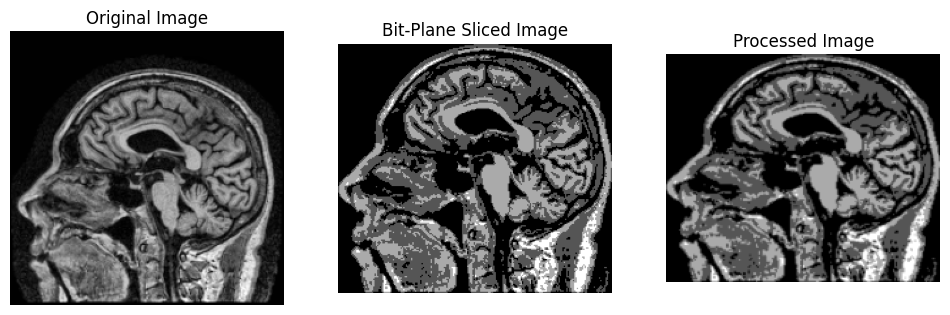

In [7]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

def intensity_normalization(volume: np.array, clip_ratio: float = 99.5):
    volume = volume - np.min(volume)
    volume_max = np.percentile(volume, clip_ratio)
    volume = np.clip(volume / volume_max, 0, 1) * 2 - 1
    return volume

def robust_crop(image: np.array):
    image_uint8 = image.astype(np.uint8)
    ret, thresh = cv2.threshold(image_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        return image[y:y+h, x:x+w]
    return image

def resize_image(image: np.array, target_size: tuple = (192, 160)):
    img_pil = Image.fromarray(image)
    resized = img_pil.resize(target_size, Image.BILINEAR)
    return np.array(resized)

def save_image(image: np.array, filename: str):
    output = ((image + 1) / 2 * 255).astype(np.uint8)
    Image.fromarray(output).save(filename)
    print(f"Saved processed image as {filename}")

def bit_plane_slicing(image: np.array, bit_planes=(7, 6)):
    bit_slices = [(image >> i) & 1 for i in bit_planes]
    combined = sum([bit * (2 ** i) for bit, i in zip(bit_slices, bit_planes)])
    return (combined / np.max(combined) * 255).astype(np.uint8)

def main():
    input_path = "I31134.png"
    output_path = "I31134_processed.png"
    
    img = Image.open(input_path).convert("L")
    img_np = np.array(img)
    print("Original image shape:", img_np.shape)
    
    cropped_img = robust_crop(img_np)
    print("Cropped image shape:", cropped_img.shape)
    
    bit_sliced_img = bit_plane_slicing(cropped_img, bit_planes=(7, 6))
    
    norm_img = intensity_normalization(bit_sliced_img, clip_ratio=99.5)
    
    norm_img_8bit = ((norm_img + 1) / 2 * 255).astype(np.uint8)
    resized_img = resize_image(norm_img_8bit, target_size=(192, 160))
    final_img = intensity_normalization(resized_img, clip_ratio=99.5)
    
    save_image(final_img, output_path)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img_np, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(bit_sliced_img, cmap="gray")
    plt.title("Bit-Plane Sliced Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    processed_img = Image.open(output_path)
    plt.imshow(processed_img, cmap="gray")
    plt.title("Processed Image")
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    main()

Original image shape: (224, 224)
Saved bit-plane sliced image as I31134_processed.png


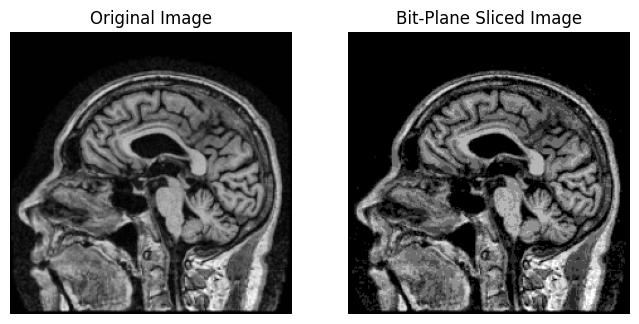

In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def bit_plane_slicing(image: np.array, bit_planes=(7, 6)):
    bit_slices = [(image >> i) & 1 for i in bit_planes]
    combined = sum([bit * (2 ** i) for bit, i in zip(bit_slices, bit_planes)])
    return (combined / np.max(combined) * 255).astype(np.uint8)

def main():
    input_path = "I31134.png"
    output_path = "I31134_processed.png"
    
    img = Image.open(input_path).convert("L")
    img_np = np.array(img)
    print("Original image shape:", img_np.shape)
    
    bit_sliced_img = bit_plane_slicing(img_np, bit_planes=[5, 6, 7])
    
    output_img = Image.fromarray(bit_sliced_img)
    output_img.save(output_path)
    print(f"Saved bit-plane sliced image as {output_path}")
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(bit_sliced_img, cmap="gray")
    plt.title("Bit-Plane Sliced Image")
    plt.axis("off")
    
    plt.show()

if __name__ == "__main__":
    main()



In [10]:
import os
import nibabel as nib
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
from skimage import exposure
from skimage.filters import unsharp_mask
from skimage.restoration import denoise_bilateral

def bit_plane_slicing(image: np.array, bit_planes=(7, 6)):
    bit_slices = [(image >> i) & 1 for i in bit_planes]
    combined = sum([bit * (2 ** i) for bit, i in zip(bit_slices, bit_planes)])
    return (combined / np.max(combined) * 255).astype(np.uint8)

def preprocess_image(nifti_file):
    img_data = nib.load(nifti_file).get_fdata()
    
    normalized_img = (img_data - img_data.min()) / (img_data.max() - img_data.min())
    middle_slice = normalized_img[:, :, normalized_img.shape[2] // 2]
    
    p2, p98 = np.percentile(middle_slice, (2, 98))
    contrast_enhanced = exposure.rescale_intensity(middle_slice, in_range=(p2, p98))
    
    sharpened_image = unsharp_mask(contrast_enhanced, radius=1.5, amount=1.5)
    
    denoised_image = denoise_bilateral(sharpened_image, sigma_color=0.05, sigma_spatial=15, channel_axis=None)
    
    denoised_uint8 = (denoised_image * 255).astype(np.uint8)
    
    bit_sliced_img = bit_plane_slicing(denoised_uint8, bit_planes=[5, 6, 7])
    
    return bit_sliced_img

input_dir = "flattened_images_2"
output_dir = "preprocessed_images_final"
os.makedirs(output_dir, exist_ok=True)

for file in os.listdir(input_dir):
    if file.endswith(".nii"):
        nifti_path = os.path.join(input_dir, file)
        processed_img = preprocess_image(nifti_path)
        output_path = os.path.join(output_dir, file.replace(".nii", ".png"))
        Image.fromarray(processed_img).save(output_path)

sample_file = os.path.join(input_dir, os.listdir(input_dir)[0])
original_img_data = nib.load(sample_file).get_fdata()
original_middle_slice = (original_img_data[:, :, original_img_data.shape[2] // 2] - original_img_data.min()) / (original_img_data.max() - original_img_data.min())
processed_img = preprocess_image(sample_file)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(original_middle_slice, cmap="gray")
axs[0].set_title("Original Middle Slice (Normalized)")
axs[0].axis("off")

axs[1].imshow(processed_img, cmap="gray")
axs[1].set_title("Bit-Plane Sliced Image")
axs[1].axis("off")

plt.tight_layout()
plt.show()

print(f"Preprocessed images saved to {output_dir}")


KeyboardInterrupt: 